Graph has 22 nodes and 24 edges.
Shortest path from node0_0_0_0 to node0_0_6_0: ['node0_0_0_0', 'sw_0_0', 'sw_0_3', 'sw_0_6', 'node0_0_6_0']


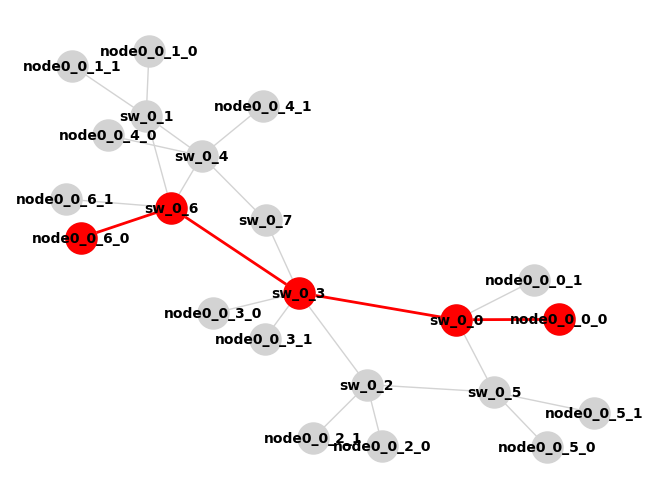

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools

class Graph:
    def __init__(self):
        # Initialize an empty NetworkX graph
        self.G = nx.Graph()

    def load_from_csv(self, topology_file):
        """
        Loads a topology from a CSV file and populates the graph with nodes and edges.

        Args:
            topology_file (str): Path to the topology CSV file.
        """
        devices = []
        links = []

        # Read the file line by line
        with open(topology_file, 'r') as file:
            for line in file:
                fields = line.strip().split(',')
                
                if fields[0] == 'SW' or fields[0] == 'ES':  # Device entry (SW or ES)
                    devices.append(fields)
                elif fields[0] == 'LINK':  # Link entry
                    links.append(fields)

        # Add nodes (SW: Switch, ES: End System)
        for device in devices:
            device_type = device[0]
            device_name = device[1]
            self.G.add_node(device_name, type=device_type)

        # Add edges (LINK)
        for link in links:
            link_id = link[1]
            source_device = link[2]
            source_port = link[3]
            destination_device = link[4]
            destination_port = link[5]
            
            # Add the edge (link) between source and destination devices
            self.G.add_edge(source_device, destination_device, link_id=link_id, source_port=source_port, destination_port=destination_port)

    def find_shortest_path(self, node_a, node_b):
        """
        Finds the shortest path between two nodes using Dijkstra's algorithm.

        Args:
            node_a (str): The source node.
            node_b (str): The destination node.

        Returns:
            path (list): The shortest path from node_a to node_b as a list of nodes.
        """
        try:
            # Use Dijkstra's algorithm to find the shortest path
            path = nx.shortest_path(self.G, source=node_a, target=node_b)
            return path
        except nx.NetworkXNoPath:
            return f"No path exists between {node_a} and {node_b}."
        except nx.NodeNotFound:
            return f"One or both of the nodes ({node_a}, {node_b}) are not in the graph."

    def draw_graph(self):
        """
        Draws the entire graph.
        """
        pos = nx.spring_layout(self.G)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
        plt.show()

    def draw_paths(self, paths):
        """
        Draws the graph with multiple paths highlighted, each with a different color.

        Args:
            paths (list): A list of paths, where each path is a list of nodes.
        """
        if not isinstance(paths, list):
            print("Paths should be a list of paths (each path is a list of nodes).")
            return

        pos = nx.spring_layout(self.G)
        # Draw the full graph in light grey
        nx.draw(self.G, pos, with_labels=True, node_color='lightgrey', edge_color='lightgrey', node_size=500, font_size=10, font_weight='bold')

        # Colors for different paths
        colors = itertools.cycle(['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan'])

        # Iterate over each path in the paths list and color them differently
        for path in paths:
            if isinstance(path, list) and len(path) > 1:
                color = next(colors)
                path_edges = list(zip(path, path[1:]))  # Get the edges of the path
                nx.draw_networkx_nodes(self.G, pos, nodelist=path, node_color=color, node_size=500)
                nx.draw_networkx_edges(self.G, pos, edgelist=path_edges, edge_color=color, width=2)
            else:
                print(f"Invalid path: {path}")

        plt.show()

# Example usage
topology_file = 'small-topology.csv'  # Replace with your actual file path
graph = Graph()
graph.load_from_csv(topology_file)

# Print information about the graph
print(f"Graph has {graph.G.number_of_nodes()} nodes and {graph.G.number_of_edges()} edges.")

# Find and print the shortest paths between multiple pairs of nodes
node_a = 'node0_0_0_0'  # Replace with actual node
node_b = 'node0_0_6_0'  # Replace with actual node

shortest_path_1 = graph.find_shortest_path(node_a, node_b)

print(f"Shortest path from {node_a} to {node_b}: {shortest_path_1}")


# Draw multiple paths on the graph
paths = [shortest_path_1]
graph.draw_paths(paths)


In [ ]:

Flow_0,38.529,12049,node0_0_0_0:e3:0->sw_0_0:e1:0->sw_0_3:e6:0->sw_0_6:e21:0->node0_0_6_0

In [ ]:
# Function to calculate the upper bound delay for a single hop, considering competing flows
def calculate_upper_bound_delay(flow, competing_flows, link_speed, headroom_rate):
    # List to store the delays of all competing flows (including the current flow)
    delays = []

    # Iterate over all competing flows (including the current flow)
    for f in competing_flows + [flow]:
        b_hat_j = f.burst_size  # Burst size of flow f
        l_j_min = f.min_frame_length  # Minimum frame length of flow f
        l_L_max = max(f.max_frame_length for f in competing_flows + [flow])  # Maximum frame length in the queue

        # Total burst from competing flows
        total_burst_competing = sum(f_comp.burst_size for f_comp in competing_flows)

        # Upper bound delay calculation for this flow
        delay = (total_burst_competing + b_hat_j - l_j_min + l_L_max) / (link_speed - headroom_rate)
        delay += l_j_min / link_speed

        # Append the delay for this flow to the list
        delays.append(delay)

    # Return the maximum delay across all competing flows
    return max(delays)

# Example of calculating end-to-end delay for a flow through its path
def calculate_end_to_end_delay_with_path(flow, network_graph, flows_on_links, headroom_rate):
    # Step 1: Dynamically calculate the path using Dijkstra's algorithm
    flow_path = calculate_path(network_graph, flow.src, flow.dest)
    
    print(f"Flow from {flow.src} to {flow.dest} takes path: {flow_path}")
    
    # Step 2: Calculate delay along the path
    total_delay = 0
    for i in range(len(flow_path) - 1):
        src = flow_path[i]
        dest = flow_path[i + 1]
        link_speed = network_graph[src][dest]['bandwidth']
        
        # Get competing flows for this link
        competing_flows = flows_on_links.get((src, dest), [])
        
        # Calculate the upper bound delay for this hop using max operation
        hop_delay = calculate_upper_bound_delay(flow, competing_flows, link_speed, headroom_rate)
        total_delay += hop_delay

        # Ensure that the sum of reserved rates on the link doesn't exceed the link capacity
        total_reserved_rate = sum(f.reserved_rate for f in competing_flows + [flow])
        if total_reserved_rate > link_speed:
            raise ValueError(f"Link {src} -> {dest} is overloaded")
    
    return total_delay

# Example usage with flows, network, and links
flows = [
    Flow(src="Switch1", dest="Switch3", priority=1, deadline=1000, nominal_frame_length=1500, reserved_rate=1e6, burst_size=10000, min_frame_length=64, max_frame_length=1500)
]

# Headroom rate and link speeds
headroom_rate = 1e6  # 1 Mbps reserved for high-priority traffic
link_speeds = {("Switch1", "Switch2"): 1e9, ("Switch2", "Switch3"): 1e9}  # Link capacities (1 Gbps)

# Dictionary to store flows on each link
flows_on_links = {("Switch1", "Switch2"): [], ("Switch2", "Switch3"): []}

# Calculate end-to-end delay for each flow
for flow in flows:
    try:
        total_delay = calculate_end_to_end_delay_with_path(flow, network_graph, flows_on_links, headroom_rate)
        if total_delay > flow.deadline:
            print(f"Flow from {flow.src} to {flow.dest} exceeds its deadline with delay {total_delay:.2f} us.")
        else:
            print(f"Flow from {flow.src} to {flow.dest} meets its deadline with delay {total_delay:.2f} us.")
    except ValueError as e:
        print(e)


In [22]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import itertools

class Flow:
    def __init__(self, src, dest, burst_size, min_frame_length, max_frame_length, reserved_rate, deadline):
        self.src = src
        self.dest = dest
        self.burst_size = burst_size
        self.min_frame_length = min_frame_length
        self.max_frame_length = max_frame_length
        self.reserved_rate = reserved_rate
        self.deadline = deadline

class Graph:
    def __init__(self):
        # Initialize an empty NetworkX graph
        self.G = nx.Graph()

    def load_from_csv(self, topology_file):
        """
        Loads a topology from a CSV file and populates the graph with nodes and edges.

        Args:
            topology_file (str): Path to the topology CSV file.
        """
        devices = []
        links = []

        # Read the file line by line
        with open(topology_file, 'r') as file:
            for line in file:
                fields = line.strip().split(',')
                
                if fields[0] == 'SW' or fields[0] == 'ES':  # Device entry (SW or ES)
                    devices.append(fields)
                elif fields[0] == 'LINK':  # Link entry
                    links.append(fields)

        # Add nodes (SW: Switch, ES: End System)
        for device in devices:
            device_type = device[0]
            device_name = device[1]
            self.G.add_node(device_name, type=device_type)

        # Add edges (LINK)
        for link in links:
            link_id = link[1]
            source_device = link[2]
            source_port = link[3]
            destination_device = link[4]
            destination_port = link[5]
            
            # Add the edge (link) between source and destination devices
            self.G.add_edge(source_device, destination_device, link_id=link_id, source_port=source_port, destination_port=destination_port)

    def find_shortest_path(self, node_a, node_b):
        """
        Finds the shortest path between two nodes using Dijkstra's algorithm.

        Args:
            node_a (str): The source node.
            node_b (str): The destination node.

        Returns:
            path (list): The shortest path from node_a to node_b as a list of nodes.
        """
        try:
            # Use Dijkstra's algorithm to find the shortest path
            path = nx.shortest_path(self.G, source=node_a, target=node_b)
            return path
        except nx.NetworkXNoPath:
            return f"No path exists between {node_a} and {node_b}."
        except nx.NodeNotFound:
            return f"One or both of the nodes ({node_a}, {node_b}) are not in the graph."

    def calculate_upper_bound_delay(self, flow, competing_flows, link_speed, headroom_rate):
        """
        Calculates the upper bound delay for a single hop, considering competing flows.

        Args:
            flow (Flow): The flow to calculate the delay for.
            competing_flows (list): List of competing flows sharing the same link.
            link_speed (float): The speed of the link in bits per second.
            headroom_rate (float): The headroom rate reserved for high-priority traffic.

        Returns:
            float: The calculated upper bound delay.
        """
        delays = []

        # Iterate over all competing flows (including the current flow)
        for f in competing_flows + [flow]:
            b_hat_j = f.burst_size  # Burst size of flow f
            l_j_min = f.min_frame_length  # Minimum frame length of flow f
            l_L_max = max(f.max_frame_length for f in competing_flows + [flow])  # Maximum frame length in the queue

            # Total burst from competing flows
            total_burst_competing = sum(f_comp.burst_size for f_comp in competing_flows)

            # Upper bound delay calculation for this flow
            delay = (total_burst_competing + b_hat_j - l_j_min + l_L_max) / (link_speed - headroom_rate)
            delay += l_j_min / link_speed

            delays.append(delay)

        # Return the maximum delay across all competing flows
        return max(delays)

    def calculate_end_to_end_delay(self, flow, flows_on_links, headroom_rate):
        """
        Calculates the total end-to-end delay for a flow.

        Args:
            flow (Flow): The flow to calculate the end-to-end delay for.
            flows_on_links (dict): Dictionary of competing flows on each link.
            headroom_rate (float): The headroom rate reserved for high-priority traffic.

        Returns:
            float: The total end-to-end delay.
        """
        # Find the path for the flow
        path = self.find_shortest_path(flow.src, flow.dest)
        total_delay = 0

        if not isinstance(path, list):
            return path  # If path is not found, return error message.

        for i in range(len(path) - 1):
            src = path[i]
            dest = path[i + 1]
            # Assume link_speed and competing flows are available from pre-loaded data
            link_speed = 1e9  # Assuming 1 Gbps link speed as an example
            competing_flows = flows_on_links.get((src, dest), [])

            # Calculate delay for this hop
            hop_delay = self.calculate_upper_bound_delay(flow, competing_flows, link_speed, headroom_rate)
            total_delay += hop_delay

        return total_delay

    def process_flows_from_csv(self, flows_csv, headroom_rate):
        """
        Processes the flows from a CSV file, calculates their upper bound delays, and outputs the result.

        Args:
            flows_csv (str): Path to the flows CSV file.
            headroom_rate (float): The headroom rate reserved for high-priority traffic.
        """
        flows_df = pd.read_csv(flows_csv, header=None, names=["ID", "FlowName", "Type", "Src", "Dest", "FrameLength", "BurstSize", "Deadline"])
        
        flows_on_links = {}  # This will be populated based on the flows sharing the same links

        result = []

        for _, row in flows_df.iterrows():
            flow = Flow(
                src=row["Src"], 
                dest=row["Dest"], 
                burst_size=row["BurstSize"], 
                min_frame_length=row["FrameLength"], 
                max_frame_length=row["FrameLength"],  # Assuming same for simplicity
                reserved_rate=1e6,  # Example reserved rate
                deadline=row["Deadline"]
            )

            # Calculate end-to-end delay
            total_delay = self.calculate_end_to_end_delay(flow, flows_on_links, headroom_rate)

            # Format the result with path details
            path = self.find_shortest_path(flow.src, flow.dest)
            if isinstance(path, list):
                path_details = "->".join(f"{path[i]}:link_id:queue_number" for i in range(len(path)-1)) + f"->{path[-1]}"
            else:
                path_details = "No path"

            result.append({
                "Flow": row["FlowName"],
                "maxE2E (us)": total_delay,
                "Deadline (us)": flow.deadline,
                "Path": path_details
            })

        # Output result
        output_df = pd.DataFrame(result)
        print(output_df)

# Example usage
graph = Graph()
graph.load_from_csv('small-topology.csv')
graph.process_flows_from_csv('small-streams.csv', headroom_rate=1e6)


       Flow  maxE2E (us)  Deadline (us)  \
0    Flow_0     0.000080          12049   
1    Flow_1     0.000009          13396   
2   Flow_10     0.000081          12910   
3   Flow_11     0.000022          19044   
4   Flow_12     0.000017          17020   
5   Flow_13     0.000007          17088   
6   Flow_14     0.000018          16154   
7   Flow_15     0.000061          15512   
8   Flow_16     0.000007          14692   
9   Flow_17     0.000008          15756   
10  Flow_18     0.000007          14909   
11  Flow_19     0.000011          13974   
12   Flow_2     0.000006          19752   
13  Flow_20     0.000081          18037   
14  Flow_21     0.000012          13328   
15  Flow_22     0.000012          18888   
16  Flow_23     0.000012          15519   
17  Flow_24     0.000015          15198   
18  Flow_25     0.000081          12311   
19  Flow_26     0.000082          18499   
20  Flow_27     0.000014          18584   
21  Flow_28     0.000102          10368   
22   Flow_3

In [ ]:

Flow_0,38.529,12049,node0_0_0_0:e3:0->sw_0_0:e1:0->sw_0_3:e6:0->sw_0_6:e21:0->node0_0_6_0
Flow_1,96.856,13396,node0_0_4_1:e20:2->sw_0_4:e17:2->sw_0_6:e6:2->sw_0_3:e9:2->node0_0_3_1
Flow_10,36.347,12910,node0_0_2_1:e24:1->sw_0_2:e5:1->sw_0_3:e6:1->sw_0_6:e22:1->node0_0_6_1
Flow_11,42.544,19044,node0_0_5_1:e12:0->sw_0_5:e2:0->sw_0_0:e1:0->sw_0_3:e6:0->sw_0_6:e21:0->node0_0_6_0
Flow_12,40.688,17020,node0_0_0_0:e3:0->sw_0_0:e1:0->sw_0_3:e6:0->sw_0_6:e22:0->node0_0_6_1
Flow_13,64.121,17088,node0_0_4_1:e20:2->sw_0_4:e17:2->sw_0_6:e21:2->node0_0_6_0
Flow_14,84.235,16154,node0_0_4_1:e20:1->sw_0_4:e17:1->sw_0_6:e6:1->sw_0_3:e8:1->node0_0_3_0